In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint, sample
from scipy.interpolate import interp1d
from pickle import dump, load
import seaborn as sns

!pip install statannot
from statannot import add_stat_annotation

from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# Do not print out pyplot outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


woi = "preseizure1"

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/My Drive/epigame-folder/game_vKarla/"

# main_folder = "/media/kivi/ADATA HV100/epigame-folder/game_vKarla"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
methods = ['PAC', 'SCR-(0,4)', 'SCI-(0,4)', 'PLV-(0,4)', 'PLI-(0,4)', 'CC-(0,4)', 'SCR-(4,8)', 'SCI-(4,8)', 'PLV-(4,8)', 'PLI-(4,8)', 'CC-(4,8)', 'SCR-(8,13)', 'SCI-(8,13)', 'PLV-(8,13)', 'PLI-(8,13)', 'CC-(8,13)', 'SCR-(13,30)', 'SCI-(13,30)', 'PLV-(13,30)', 'PLI-(13,30)', 'CC-(13,30)', 'SCR-(30,70)', 'SCI-(30,70)', 'PLV-(30,70)', 'PLI-(30,70)', 'CC-(30,70)', 'SCR-(70,150)', 'SCI-(70,150)', 'PLV-(70,150)', 'PLI-(70,150)', 'CC-(70,150)']

In [34]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "0,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
# cm_subs = {
#     "SC_R": "Real spectral coherence",
#     "SC_I": "Imaginary spectral coherence",
#     "PLV": "Phase-locking value",
#     "PLI": "Phase lag index",
#     "CC": "Cross-correlation",
#     "PAC": "PAC",
#     "PEC": "PEC"
# }

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace('-','').replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
# def substitute_cm(s):
#     # Find all occurrences of connectivity method prefixes
#     for cm in cm_subs:
#         s = re.sub(r'\b' + cm+ r'\b', cm_subs[cm], s)

#     return s

# Test
input_str = "CC-(30,70), SC_R-(70,150)"
# output_str = substitute_cm(input_str)
output_str = substitute_bands(input_str)

print(output_str)

CC (low γ), SC_R (high γ)


In [27]:
# Function for generating box pairs that will be compared using a statistical test
def generate_box_pairs(method):
  return [(("{}".format(method), 1), ("{}".format(method), 0))]

In [38]:
sigma = 4
load_data = []
while sigma > 0:
    load_data = pd.read_excel(main_folder + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

    # Check if "Mean_overlap_ratio" contains any zeros
    zero_row_indices = load_data.index[load_data["Mean_overlap_ratio"] == 0].tolist()

    if zero_row_indices:
        print(f"Zeros found in rows {zero_row_indices} for sigma={sigma}")
        if sigma == 1:
            print("Skipping iteration for sigma=1 with zeros")
            break

        sigma -= 1
        prev_load_data = pd.read_excel(main_folder + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

        for zero_row_index in zero_row_indices:
            zero_value = prev_load_data.loc[zero_row_index, "Mean_overlap_ratio"]
            load_data.loc[zero_row_index, "Mean_overlap_ratio"] = zero_value
    else:
        break  # No zeros found, exit the loop



Zeros found in rows [100, 101, 103, 104, 107, 108, 110, 113, 115, 118, 119, 121, 122, 123, 149, 154, 248, 253, 254, 256, 257, 258, 259, 261, 263, 268, 273, 278, 295, 403, 407, 408, 409, 410, 412, 413, 415, 422, 423, 427, 428, 429, 431, 432, 433, 439, 440, 454, 558, 566, 568, 569, 570, 572, 573, 576, 578, 579, 580, 581, 583, 584, 588, 599, 600, 606, 609, 665, 714, 721, 730, 732, 734, 736, 737, 741, 742, 743, 754, 765, 766, 814, 853, 857, 860, 868, 869, 870, 872, 873, 874, 875, 876, 877, 878, 879, 881, 882, 883, 884, 885, 886, 888, 889, 890, 892, 893, 894, 895, 897, 898, 902, 907, 908, 909, 916, 919, 920, 925, 929, 1023, 1029, 1030, 1033, 1034, 1036, 1038, 1040, 1043, 1048, 1051, 1052, 1053, 1178, 1180, 1185, 1187, 1188, 1193, 1195, 1196, 1198, 1199, 1201, 1202, 1203, 1204, 1206, 1208, 1234, 1236, 1239, 1297, 1333, 1339, 1341, 1343, 1348, 1353, 1358, 1359, 1360, 1363, 1385, 1495, 1496, 1497, 1498, 1503, 1505, 1510, 1512, 1513, 1514, 1515, 1517, 1518, 1530, 1533, 1643, 1645, 1648, 1649, 1

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PAC', 1), ('PAC', 0)) stat=4.70e+01 p-value=9.13e-01
pvalues: [0.91312349501204]


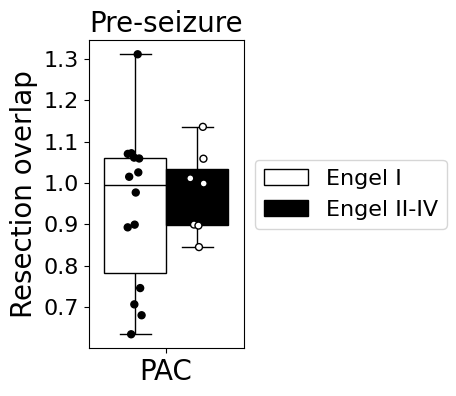

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(0,4)', 1), ('SCR-(0,4)', 0)) stat=7.60e+01 p-value=4.61e-02
pvalues: [0.04609563123495012]


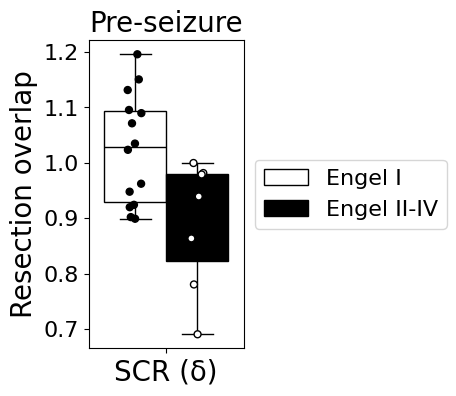

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(0,4)', 1), ('SCI-(0,4)', 0)) stat=7.30e+01 p-value=7.93e-02
pvalues: [0.07932576539387685]


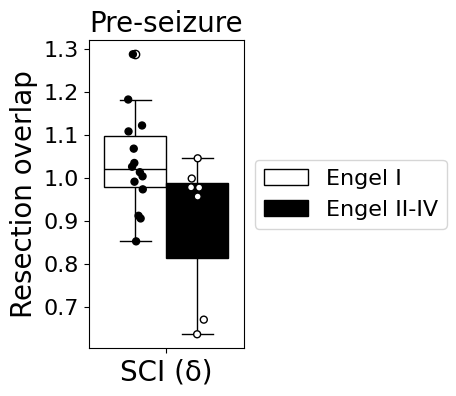

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(0,4)', 1), ('PLV-(0,4)', 0)) stat=7.00e+01 p-value=1.28e-01
pvalues: [0.12846577227382183]


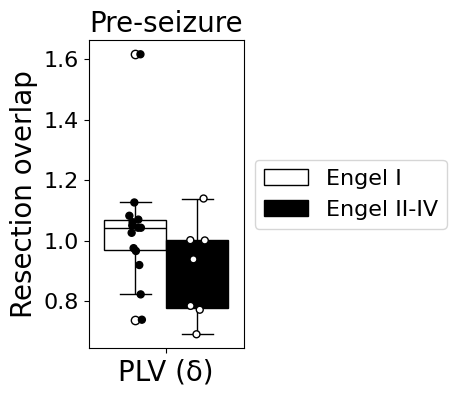

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(0,4)', 1), ('PLI-(0,4)', 0)) stat=4.50e+01 p-value=7.99e-01
pvalues: [0.7990024079807363]


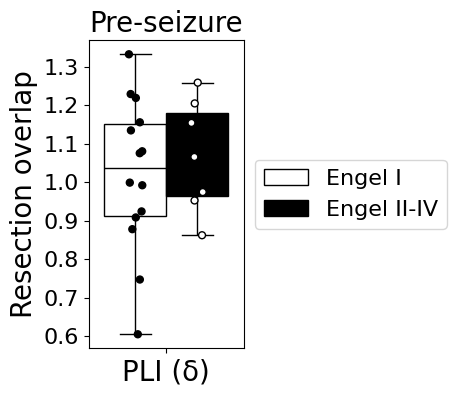

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(0,4)', 1), ('CC-(0,4)', 0)) stat=3.10e+01 p-value=1.97e-01
pvalues: [0.19686962504299968]


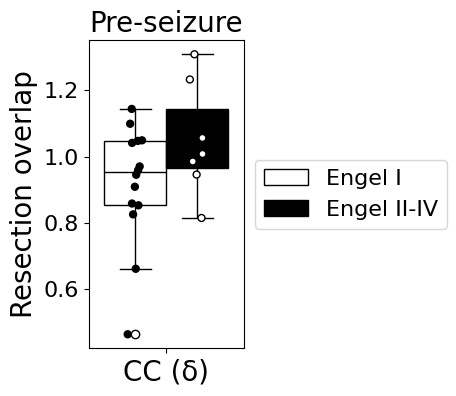

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(4,8)', 1), ('SCR-(4,8)', 0)) stat=2.90e+01 p-value=1.49e-01
pvalues: [0.14895080839353286]


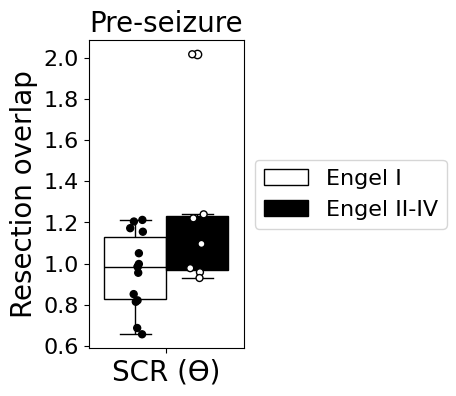

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(4,8)', 1), ('SCI-(4,8)', 0)) stat=4.60e+01 p-value=8.56e-01
pvalues: [0.8557447540419678]


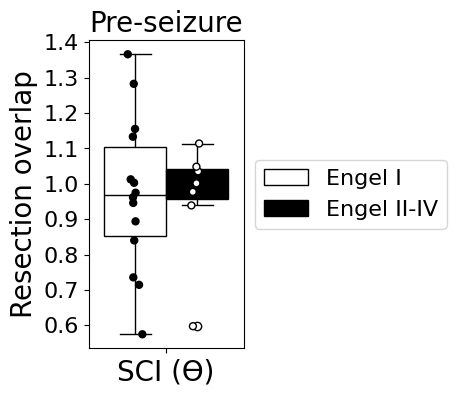

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(4,8)', 1), ('PLV-(4,8)', 0)) stat=6.90e+01 p-value=1.49e-01
pvalues: [0.14895080839353286]


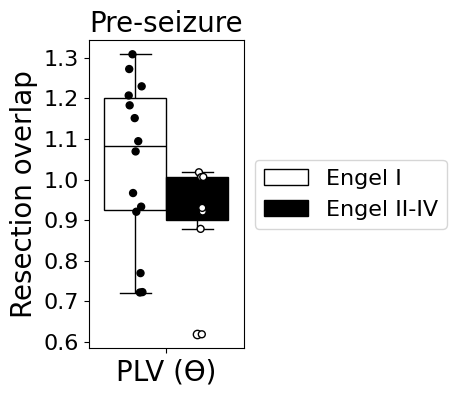

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(4,8)', 1), ('PLI-(4,8)', 0)) stat=9.00e+01 p-value=1.14e-03
pvalues: [0.0011351909184726522]


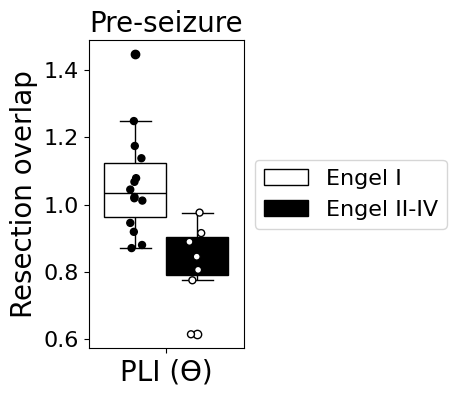

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(4,8)', 1), ('CC-(4,8)', 0)) stat=5.40e+01 p-value=7.43e-01
pvalues: [0.743326453388373]


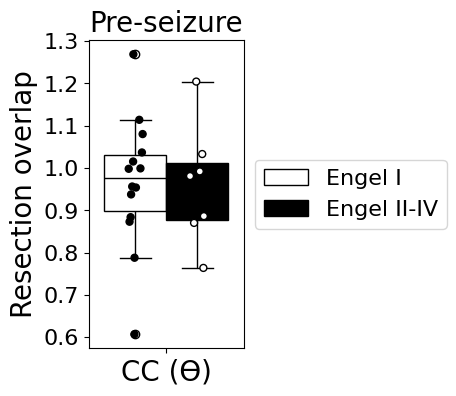

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(8,13)', 1), ('SCR-(8,13)', 0)) stat=6.20e+01 p-value=3.60e-01
pvalues: [0.360061919504644]


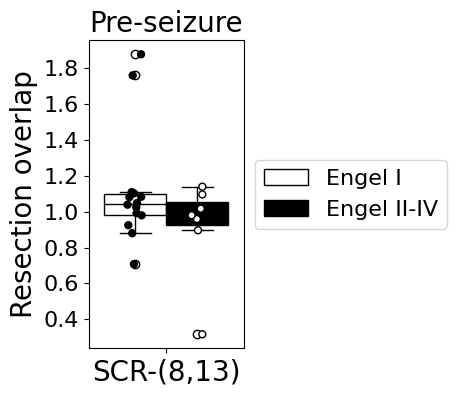

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(8,13)', 1), ('SCI-(8,13)', 0)) stat=4.90e+01 p-value=1.00e+00
pvalues: [1.0]


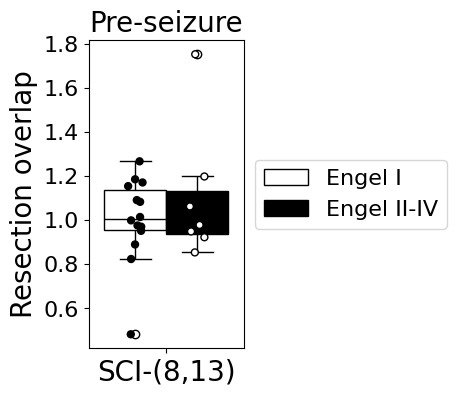

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(8,13)', 1), ('PLV-(8,13)', 0)) stat=3.60e+01 p-value=3.60e-01
pvalues: [0.360061919504644]


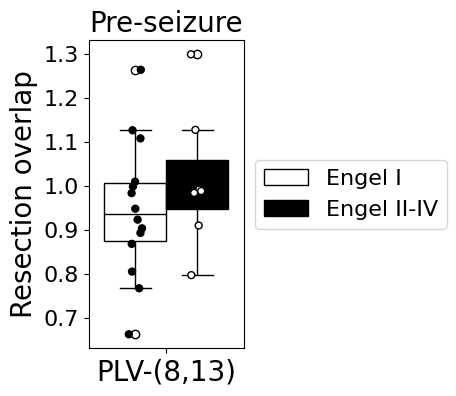

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(8,13)', 1), ('PLI-(8,13)', 0)) stat=5.50e+01 p-value=6.89e-01
pvalues: [0.6888200894392846]


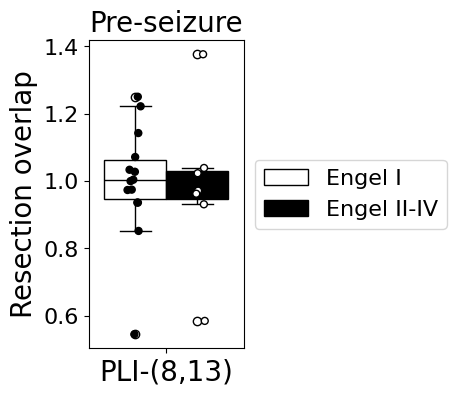

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(8,13)', 1), ('CC-(8,13)', 0)) stat=4.30e+01 p-value=6.89e-01
pvalues: [0.6888200894392846]


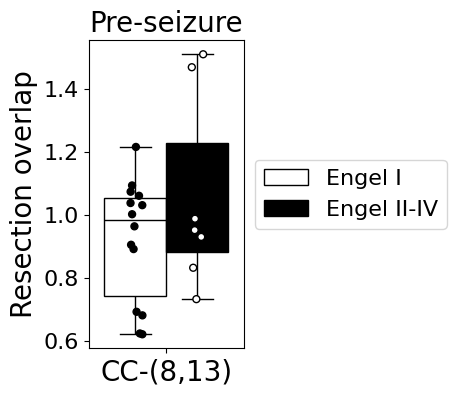

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(13,30)', 1), ('SCR-(13,30)', 0)) stat=5.30e+01 p-value=7.99e-01
pvalues: [0.7990024079807363]


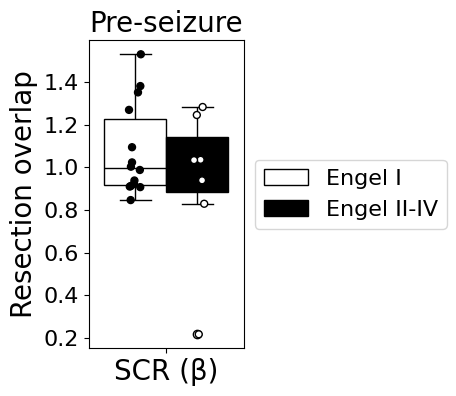

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(13,30)', 1), ('SCI-(13,30)', 0)) stat=4.70e+01 p-value=9.13e-01
pvalues: [0.91312349501204]


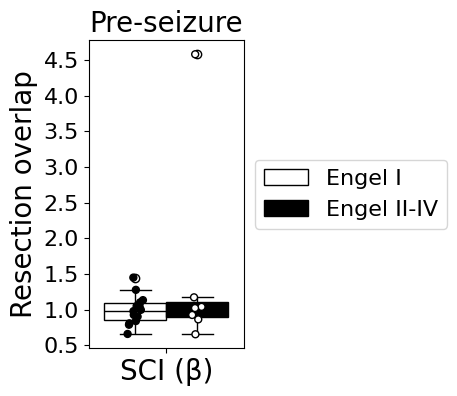

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(13,30)', 1), ('PLV-(13,30)', 0)) stat=5.30e+01 p-value=7.99e-01
pvalues: [0.7990024079807363]


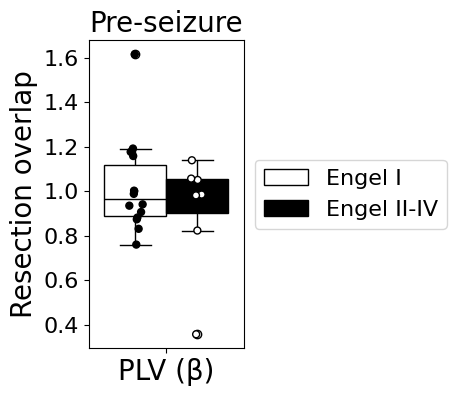

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(13,30)', 1), ('PLI-(13,30)', 0)) stat=5.10e+01 p-value=9.13e-01
pvalues: [0.91312349501204]


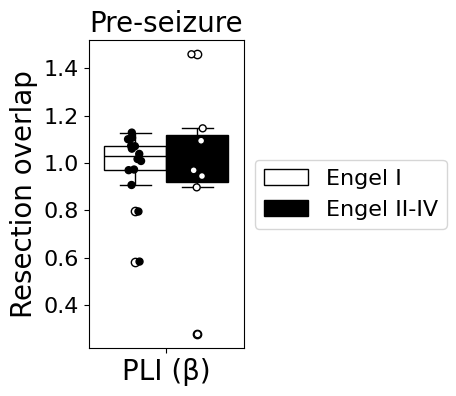

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(13,30)', 1), ('CC-(13,30)', 0)) stat=3.30e+01 p-value=2.55e-01
pvalues: [0.25452356381148955]


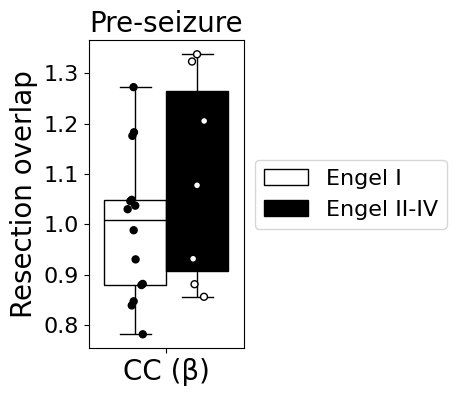

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(30,70)', 1), ('SCR-(30,70)', 0)) stat=6.10e+01 p-value=4.00e-01
pvalues: [0.4002579979360166]


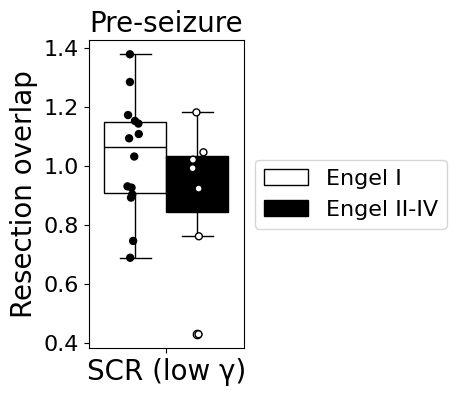

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(30,70)', 1), ('SCI-(30,70)', 0)) stat=5.10e+01 p-value=9.13e-01
pvalues: [0.91312349501204]


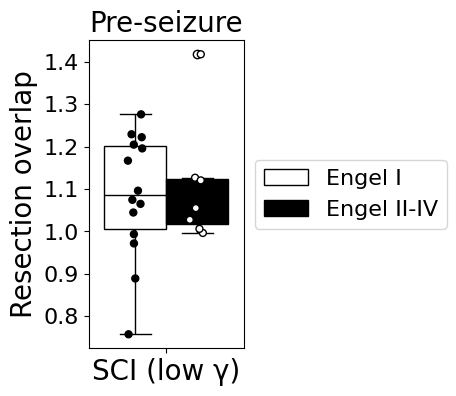

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(30,70)', 1), ('PLV-(30,70)', 0)) stat=5.20e+01 p-value=8.56e-01
pvalues: [0.8557447540419678]


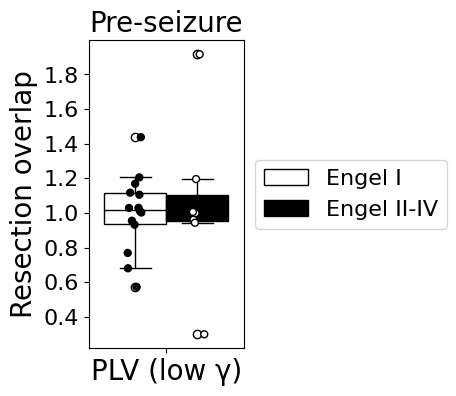

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(30,70)', 1), ('PLI-(30,70)', 0)) stat=4.90e+01 p-value=1.00e+00
pvalues: [1.0]


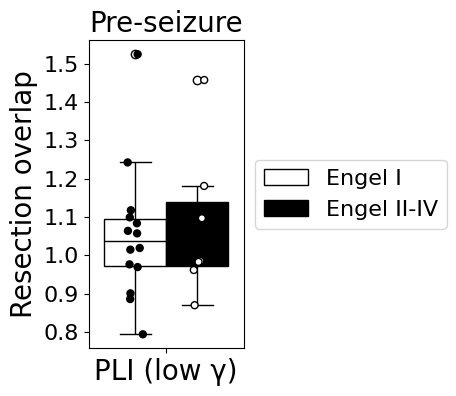

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(30,70)', 1), ('CC-(30,70)', 0)) stat=5.20e+01 p-value=8.56e-01
pvalues: [0.8557447540419678]


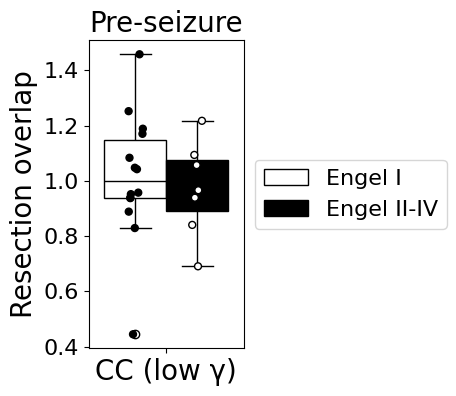

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCR-(70,150)', 1), ('SCR-(70,150)', 0)) stat=3.10e+01 p-value=1.97e-01
pvalues: [0.19686962504299968]


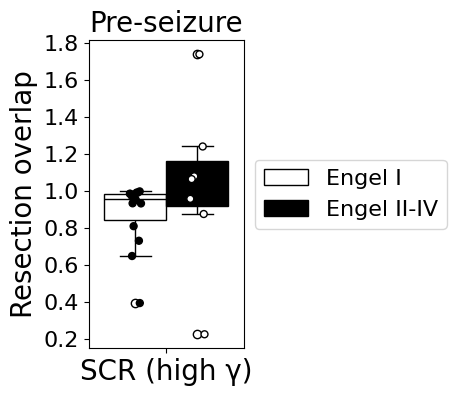

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('SCI-(70,150)', 1), ('SCI-(70,150)', 0)) stat=3.50e+01 p-value=3.22e-01
pvalues: [0.3223082215342278]


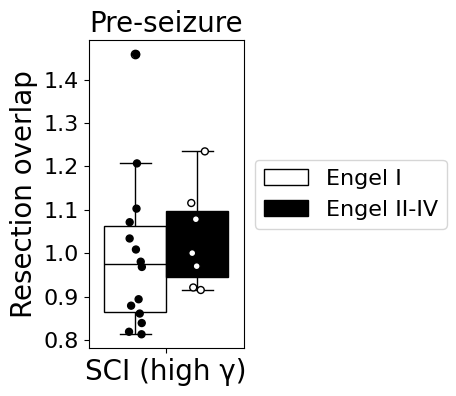

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLV-(70,150)', 1), ('PLV-(70,150)', 0)) stat=3.10e+01 p-value=1.97e-01
pvalues: [0.19686962504299968]


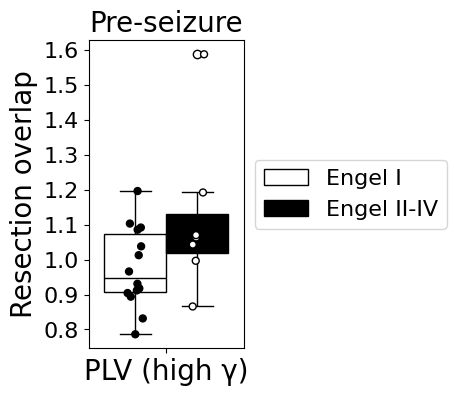

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('PLI-(70,150)', 1), ('PLI-(70,150)', 0)) stat=4.90e+01 p-value=1.00e+00
pvalues: [1.0]


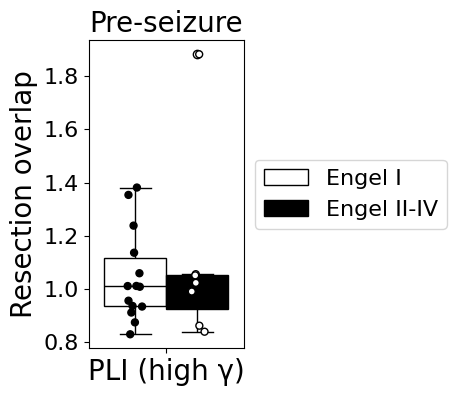

Performing MannWhitneyU Two-sided statistical test for equal variances on pair: (('CC-(70,150)', 1), ('CC-(70,150)', 0)) stat=3.90e+01 p-value=4.88e-01
pvalues: [0.48796009631922954]


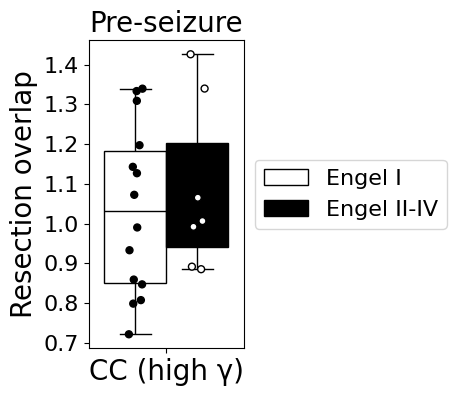

In [39]:
data = None

woi_str = "Pre-seizure"

summary_stat_label = ["mm"]

for summary_stat in summary_stat_label:

  for cm in methods:

    data = load_data.groupby("CM").get_group(cm).groupby("Strategy").get_group(summary_stat)

    box_pairs = generate_box_pairs(cm)

    test_short_name = 'MannWhitneyU Two-sided'

    pvalues = []

    for pair in box_pairs:

        data1 = data.groupby("CM").get_group(pair[0][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[0][1])
        data2 = data.groupby("CM").get_group(pair[1][0]).groupby("Outcome")["Mean_overlap_ratio"].get_group(pair[1][1])

        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        print("Performing %s statistical test for equal variances on pair:"%test_short_name, pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(p)

    print("pvalues:", pvalues)

    palette_box = {1:"white", 0:"black"}
    palette_strip = {0:"white", 1:"black"}

    plt.figure(figsize=(2,4))

    bp = sns.boxplot(y="Mean_overlap_ratio", x="CM", data=data, palette=palette_box, hue="Outcome", hue_order=[1,0])
    bp = sns.stripplot(y="Mean_overlap_ratio", x="CM", data=data, jitter=True, dodge=True, marker="o", ax=bp, hue="Outcome", hue_order=[1,0], palette=palette_strip, linewidth=1, edgecolor="black")

    handles, labels = bp.get_legend_handles_labels()
    plt.legend(handles[0:2], ["Engel I", "Engel II-IV"], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title("%s"%woi_str, size=20)
    plt.yticks(fontsize=16)
    plt.xticks([0], [substitute_bands(cm)], fontsize=20)
    plt.ylabel("Resection overlap", fontsize=20)
    plt.xlabel('')
    # add_stat_annotation(bp, data=data, y="Mean_overlap_ratio", x="CM", hue="Outcome",
    #                             box_pairs=box_pairs, perform_stat_test=False, pvalues=pvalues, test_short_name=test_short_name,text_format='star', fontsize="large", linewidth=2, loc='inside', verbose=2)

    plt.show()
    # plt.savefig("D:/%s.png"%t)
    plt.close()